**CMP585 - Structural Bioinformatics**

Cristian Lopes

*Assignment 2*

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import time

# Load Data

In [2]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                atoms.append({'atom_name': line[12:16].strip(), 
                             'residue_name': line[17:20].strip(),
                             'residue_seq_number': line[22:26].strip(),
                             'x': float(line[30:38].strip()), 
                             'y': float(line[38:46].strip()),
                             'z': float(line[46:54].strip())})
    return pd.DataFrame(atoms)

In [3]:
molecule = read_molecule('./data/1crn.pdb')

In [4]:
molecule.head(20)

,atom_name,residue_name,residue_seq_number,x,y,z
0,N,THR,1,17.047,14.099,3.625
1,CA,THR,1,16.967,12.784,4.338
2,C,THR,1,15.685,12.755,5.133
3,O,THR,1,15.268,13.825,5.594
4,CB,THR,1,18.170,12.703,5.337
5,OG1,THR,1,19.334,12.829,4.463
6,CG2,THR,1,18.150,11.546,6.304
7,N,THR,2,15.115,11.555,5.265
8,CA,THR,2,13.856,11.469,6.066
9,C,THR,2,14.164,10.785,7.379


# Q1) Primary to Tertiary Structure

## Symbol of each amino acid

First of all, we define the symbol of each amino acid.

In [5]:
symbol_to_residue_name = {
    'T': 'THR', 'C': 'CYS', 'P': 'PRO', 'S': 'SER', 'I': 'ILE',
    'V': 'VAL', 'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'F': 'PHE',
    'L': 'LEU', 'G': 'GLY', 'E': 'GLU', 'D': 'ASP', 'Y': 'TYR'
}

## Load Amino Acids 

Then, we load the amino acids from the Protein Data Bank.

In [6]:
AMINOACID_PATH = './data/amino_acids/'
aminoacids = pd.DataFrame()

for f in glob.glob(AMINOACID_PATH + "*.pdb"):
    aminoacids = aminoacids.append(read_molecule(f))

Right now, we have a dictionnary of amino acids containing the position of each atom inside the amino acid.

## Primary structure to tertiary structure

### Translation and Rotation

Next step is to replace each symbol of the primary structure by its corresponding residue. First, we define a translation and a rotation function to move and rotate the next amino acid given the position of the previous aminoacid.

In [7]:
def translate(aminoacid, translation):
    aminoacid[['x', 'y', 'z']] = aminoacid[['x', 'y', 'z']] + translation
    return aminoacid

In [8]:
def translation_to_origin(aminoacid, ref_atom='N'):
    ref_translation = aminoacid[aminoacid.atom_name == ref_atom][['x', 'y', 'z']].values.reshape(-1)
    return ref_translation, translate(aminoacid, -ref_translation)
    

def rotate(aminoacid, angle_x, angle_y, angle_z):  
    Rx = [[1, 0, 0], [0, np.cos(angle_x), -np.sin(angle_x)], [0, np.sin(angle_x), np.cos(angle_x)]]
    Ry = [[np.cos(angle_y), 0, np.sin(angle_y)], [0, 1, 0], [-np.sin(angle_y), 0, np.cos(angle_y)]]
    Rz = [[np.cos(angle_z), -np.sin(angle_z), 0], [np.sin(angle_z), np.cos(angle_z), 0], [0, 0, 1]]
    R = np.dot(np.dot(Rx, Ry), Rz)
    
    ref_translation, aminoacid = translation_to_origin(aminoacid)
    aminoacid[['x', 'y', 'z']] = R.dot(aminoacid[['x', 'y', 'z']].values.T).T
    aminoacid = translate(aminoacid, ref_translation)
    
    return aminoacid

### Planar Peptide Bond Constraints

Given the position of  O and C (Carboxyl) from the previous amino acid and the position of N from the next one, we can calculate the necessary translation and rotation in the next amino acid in order to form a planar peptide bond, that means, Omega equals to 180° (considering a distance of 1.33 ångström between C and N, an angle of 123,5° (trans) or 123,0° (cis) between O-C and C-N and an angle of 116,0° (trans) or 118,0° (cis) between Ca-C and C-N as shown in the figure below).

<div style="text-align:center"><img width="600px" src="./images/planar_peptide_bond.png"/></div>
<br>
<br>
<div style="text-align:center">Figure 1:  The average dimensions of the planar peptide group (in angstroms and degrees).</div>
<div style="text-align:center">Source: https://www.open.edu/openlearn/science-maths-technology/science/biology/proteins/content-section-1.2)</div>

In [9]:
# distance between Ci and Ni+1 should be 1.33 ångström
def calculate_distance(p1, p2):
    return np.sqrt(np.sum((p1-p2) ** 2))

In [10]:
# angle between Oi-Ci and Ci-Ni+1 should be 123.5° (trans) or 123.0° (cis)
# angle between Calphai-Ci and Ci-Ni+1 should be 116.0° (trans) or 118.0° (cis)
def calculate_angle(p1, p2, p3):
    p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)
    
    p1_ref = p1 - p2
    p3_ref = p3 - p2
    
    cosine_angle = np.dot(p1_ref, p3_ref) / (np.linalg.norm(p1_ref) * np.linalg.norm(p3_ref))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

In [11]:
# dihedral angle between Calphai-Ci-Ni+1 and Ci-Ni+1-Calphai+1 should be 180°
def calculate_dihedral_angle(p1, p2, p3, p4):
    p1, p2, p3, p4 = np.array(p1), np.array(p2), np.array(p3), np.array(p4)
    
    b1 = -1.0 * (p2 - p1)
    b2 = p3 - p2
    b3 = p4 - p3
    
    # normalize b2
    b2 /= np.linalg.norm(b2)
    
    # projections of b1 and b3 onto plane perpendicular to b2
    v = b1 - np.dot(b1, b2) * b2
    w = b3 - np.dot(b3, b2) * b2
    
    # angle between v and w is the torsion angle
    cosine_angle = np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))
    dihedral_angle = np.arccos(cosine_angle)
    return np.degrees(np.abs(dihedral_angle))

### Calculate Next Amino Acid Translation and Rotation

Based on the constraints, we can calculate the translation and rotation of the next amino acid given the previous one. We are going to use the Genetic Algorithm to calculate the necessary translation and rotation in order to satisfy the constraints.

In [12]:
class GeneticAlgorithm:
    def __init__(self, dim_populaton, n_population, previous_aminoacid, next_aminoacid, peptide_group='trans'):
        self.DIM_POPULATION = dim_populaton
        self.N_POPULATION = n_population
        self.peptide_group = peptide_group
        
        self.distances = []
        self.dihedral_angles = []
        self.angles_ocn = []
        self.angles_ccn = []
        self.average_fitness = []
        
        self.previous_aminoacid = previous_aminoacid
        self.next_aminoacid = next_aminoacid

        self.population = self.initialize_population()
        self.fitness = self.compute_population_fitness()
        self.previous_fitness = None

        self.iteration = 0


    # Initialization
    def initialize_population(self):
        c_previous = self.previous_aminoacid[self.previous_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)
        n_next = self.next_aminoacid[self.next_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)
        
        initial_amplitude = np.array([calculate_distance(c_previous, n_next)] * 3 + [1] * 3)
        initial_population = [initial_amplitude * np.random.uniform(-1, 1, self.DIM_POPULATION) 
                              for _ in range(self.N_POPULATION)]

        return initial_population

    def generate_new_population(self):
        new_population = []
        for _ in range(self.N_POPULATION // 2):
            childrens = self.intermediate_recombination()
            new_population.extend([self.gaussian_convolution(children) for children in childrens])

        return new_population

    # Fitness
    def individual_fitness(self, o_previous, c_previous, n_next, c_alpha_previous, c_alpha_next):
        desired_dihedral_angle = 180.0
        
        if self.peptide_group == 'trans':
            desired_distance = 1.33
            desired_angle_ocn = 123.5
            desired_angle_ccn = 116.0
        elif self.peptide_group == 'cis':
            desired_distance = 1.32
            desired_angle_ocn = 123.0
            desired_angle_ccn = 118.0
        
        distance = calculate_distance(c_previous, n_next)
        dihedral_angle = calculate_dihedral_angle(c_alpha_previous, c_previous, n_next, c_alpha_next)
        angle_ocn = calculate_angle(o_previous, c_previous, n_next)
        angle_ccn = calculate_angle(c_alpha_previous, c_previous, n_next)
        
        self.distances.append(distance)
        self.dihedral_angles.append(dihedral_angle)
        self.angles_ocn.append(angle_ocn)
        self.angles_ccn.append(angle_ccn)
        
        fitness = (
            np.abs(distance - desired_distance) / desired_distance +
            np.abs(dihedral_angle - desired_dihedral_angle) / desired_dihedral_angle +
            10*np.abs(angle_ocn - desired_angle_ocn) / desired_angle_ocn +
            10*np.abs(angle_ccn - desired_angle_ccn) / desired_angle_ccn
        )
        
        return fitness

    def compute_population_fitness(self):
        population_fitness = []
        for individual in self.population:
            p_aminoacid = self.previous_aminoacid.copy()
            n_aminoacid = self.next_aminoacid.copy()
            n_aminoacid = translate(n_aminoacid, individual[:3])
            n_aminoacid = rotate(n_aminoacid, individual[3], individual[4], individual[5])
            
            o_previous = p_aminoacid[p_aminoacid.atom_name == 'O'][['x', 'y', 'z']].values.reshape(-1)
            c_previous = p_aminoacid[p_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)
            n_next = n_aminoacid[n_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)
            c_alpha_previous = p_aminoacid[p_aminoacid.atom_name == 'CA'][['x', 'y', 'z']].values.reshape(-1)
            c_alpha_next = n_aminoacid[n_aminoacid.atom_name == 'CA'][['x', 'y', 'z']].values.reshape(-1)

            population_fitness.append(self.individual_fitness(o_previous, c_previous, n_next, c_alpha_previous, c_alpha_next))

        return population_fitness
    
    # Selection
    def fitness_proportionate_selection(self):
        probabilities = (np.max(self.fitness) - self.fitness) / np.sum(np.max(self.fitness) - self.fitness)
        idx = np.random.choice(self.N_POPULATION, replace=True, p=probabilities)

        return self.population[idx]

    # Crossover
    def intermediate_recombination(self):
        p = 0.1
        alpha = np.random.uniform(-p, 1+p)
        beta = np.random.uniform(-p, 1+p)

        parent_1 = self.fitness_proportionate_selection()
        parent_2 = self.fitness_proportionate_selection()

        children_1 = alpha * parent_1 + (1 - alpha) * parent_2
        children_2 = beta * parent_1 + (1 - beta) * parent_2

        return [children_1, children_2]

    # Mutation
    def gaussian_convolution(self, children):
        add_noise_prob = np.random.rand(self.DIM_POPULATION)

        sigma = 0.02
        noise = sigma * np.random.randn(self.DIM_POPULATION)

        return children + noise * (add_noise_prob > 0.5)

    def done(self, epsilon, max_iteration):
        converged = (np.abs(np.mean(self.fitness) - np.mean(self.previous_fitness)) < epsilon) \
                     if self.previous_fitness is not None else False
        taking_too_long = self.iteration > max_iteration

        return converged or taking_too_long

    def show_results(self):
        print('\nOptimal Solution:\n')
        print('Tx: %.2fÅ, Ty: %.2fÅ, Tz: %.2fÅ' % tuple(self.population[np.argmin(self.fitness)][:3]))
        print('Ax: %.2f°, Ay: %.2f°, Az: %.2f°' % tuple(np.degrees(self.population[np.argmin(self.fitness)][3:])))
        
        print('\nOptimized Metrics:\n')
        print('Distance C-N: %.4f' % self.distances[-self.N_POPULATION + np.argmin(self.fitness)])
        print('Omega Dihedral Angle: %.2f' % self.dihedral_angles[-self.N_POPULATION + np.argmin(self.fitness)])
        print('Angle O-C-N: %.2f' % self.angles_ocn[-self.N_POPULATION + np.argmin(self.fitness)])
        print('Angle Calpha-C-N: %.2f\n' % self.angles_ccn[-self.N_POPULATION + np.argmin(self.fitness)])
        
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(22, 5))
        ax1.plot(self.average_fitness)
        ax1.set_title('Average Fitness Convergence.')
        ax2.plot(np.convolve(self.distances, np.ones((10,)) / 10, mode='valid'))
        ax2.set_title('Distance C-N.')
        ax2.axis([-100, len(self.distances) + 100, 0, 5])
        ax3.plot(np.convolve(self.dihedral_angles, np.ones((10,)) / 10, mode='valid'))
        ax3.set_title('Omega Dihedral Angle.')
        ax3.axis([-100, len(self.dihedral_angles) + 100, 0, 185])
        ax4.plot(np.convolve(self.angles_ocn, np.ones((10,)) / 10, mode='valid'))
        ax4.set_title('Angle O-C-N.')
        ax4.axis([-100, len(self.angles_ocn) + 100, 0, 185])
        ax5.plot(np.convolve(self.angles_ccn, np.ones((10,)) / 10, mode='valid'))
        ax5.set_title('Angle Calpha-C-N.')
        ax5.axis([-100, len(self.angles_ccn) + 100, 0, 185])
        plt.show()
        
    def optimize(self, max_iteration=500):
        self.iteration = 0
        
        while not self.done(epsilon=1e-8, max_iteration=max_iteration):
            self.iteration += 1
            self.previous_fitness = self.fitness

            self.population = self.generate_new_population()
            self.fitness = self.compute_population_fitness()

            self.average_fitness.append(np.mean(self.fitness))

        self.show_results()
        
        return self.population[np.argmin(self.fitness)][:3], self.population[np.argmin(self.fitness)][3:]

#### Testing next amino acid traslation and rotation

In [13]:
previous_aminoacid = aminoacids[aminoacids.residue_name == 'THR']
next_aminoacid = aminoacids[aminoacids.residue_name == 'THR']

In [14]:
g = GeneticAlgorithm(6, 10, previous_aminoacid, next_aminoacid)


Optimal Solution:

Tx: 3.27Å, Ty: 1.61Å, Tz: 0.01Å
Ax: 10.59°, Ay: 38.40°, Az: 17.98°

Optimized Metrics:

Distance C-N: 1.3227
Omega Dihedral Angle: 125.46
Angle O-C-N: 123.12
Angle Calpha-C-N: 114.89



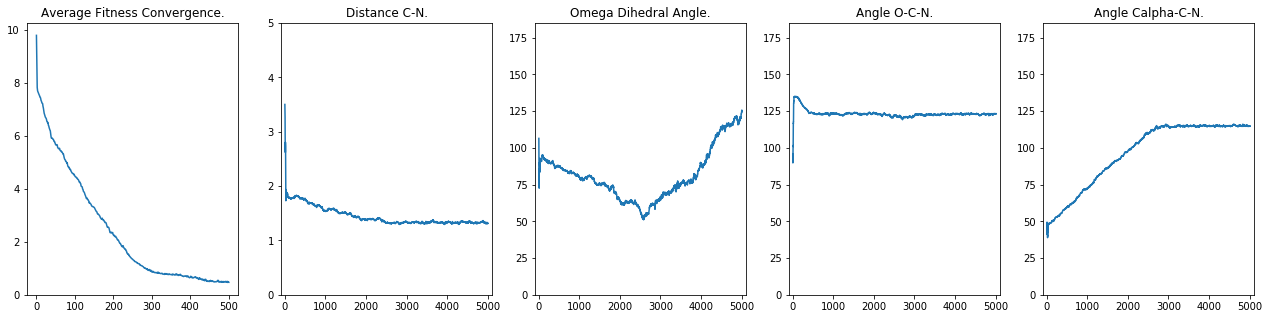

In [15]:
translation, rotation = g.optimize(500)

### Generate Tertiary Structure

Once we have a way to calculate the translation and rotation of the next aminoacidd in the chain given the previous one, we can implement the routine to generate the tertiary structure of a protein given the primary structure.

In [16]:
primary_structure = 'TTCC'
# primary_structure = 'TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATCPGDYAN'

In [17]:
def _infer_tertiary_structure(primary_structure, aminoacids_df):
    protein = pd.DataFrame(data=None, columns=['atom_name', 'residue_name', 'residue_seq_number', 'x', 'y', 'z'])    
    previous_aminoacid = None
    
    for i, r in enumerate(primary_structure):
        print('Adding amino acid %s...' % symbol_to_residue_name[r])
        aminoacid = aminoacids_df[aminoacids_df.residue_name == symbol_to_residue_name[r]].copy()
              
        if previous_aminoacid is not None:
            time.sleep(2)
            peptide_group = 'cis' if symbol_to_residue_name[r] == 'PRO' else 'trans'
            ga = GeneticAlgorithm(dim_populaton=6, n_population=10,
                                  previous_aminoacid=previous_aminoacid, next_aminoacid=aminoacid,
                                  peptide_group=peptide_group)
            translation, rotation = ga.optimize(max_iteration=1000)
            aminoacid = translate(aminoacid, translation)
            aminoacid = rotate(aminoacid, rotation[0], rotation[1], rotation[2])
        else:
            print('This is the first amino acid.')
        
        aminoacid['residue_seq_number'] = str(i)
        
        previous_aminoacid = aminoacid
        protein = protein.append(aminoacid, sort=True, ignore_index=True)
        print('Amino acid %s added.\n' % symbol_to_residue_name[r])

    return protein

Adding amino acid THR...
This is the first amino acid.
Amino acid THR added.

Adding amino acid THR...

Optimal Solution:

Tx: 3.28Å, Ty: 1.62Å, Tz: -0.05Å
Ax: 3.37°, Ay: 4.34°, Az: 48.65°

Optimized Metrics:

Distance C-N: 1.3373
Omega Dihedral Angle: 179.02
Angle O-C-N: 122.75
Angle Calpha-C-N: 115.22



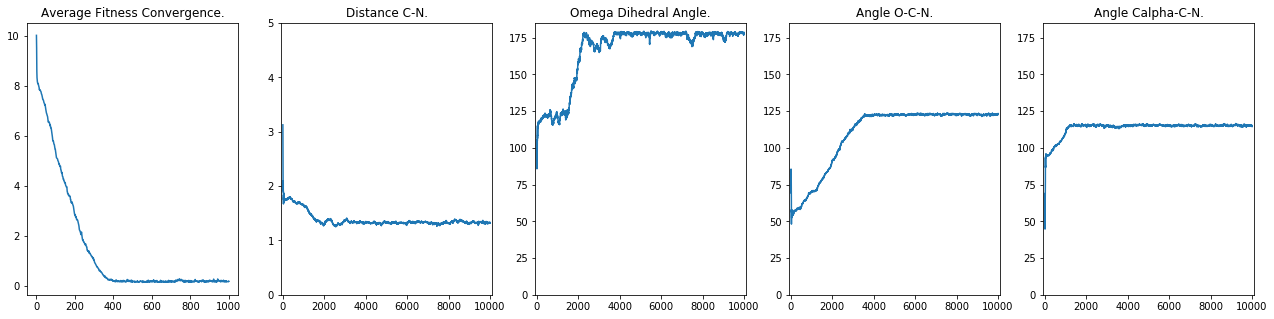

Amino acid THR added.

Adding amino acid CYS...

Optimal Solution:

Tx: 4.20Å, Ty: 5.19Å, Tz: 0.14Å
Ax: -114.31°, Ay: -63.52°, Az: -29.97°

Optimized Metrics:

Distance C-N: 1.3205
Omega Dihedral Angle: 179.84
Angle O-C-N: 122.92
Angle Calpha-C-N: 115.04



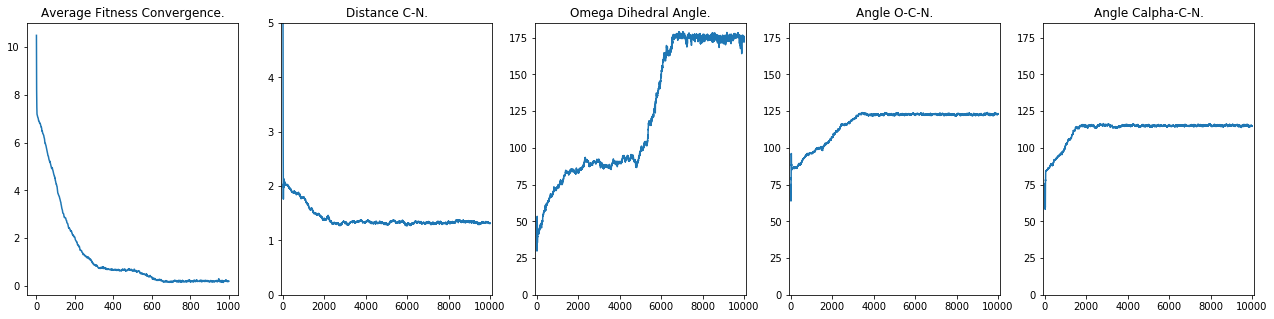

Amino acid CYS added.

Adding amino acid CYS...

Optimal Solution:

Tx: 5.85Å, Ty: 8.20Å, Tz: -1.14Å
Ax: 21.86°, Ay: 76.42°, Az: -24.55°

Optimized Metrics:

Distance C-N: 1.3327
Omega Dihedral Angle: 179.14
Angle O-C-N: 122.87
Angle Calpha-C-N: 115.06



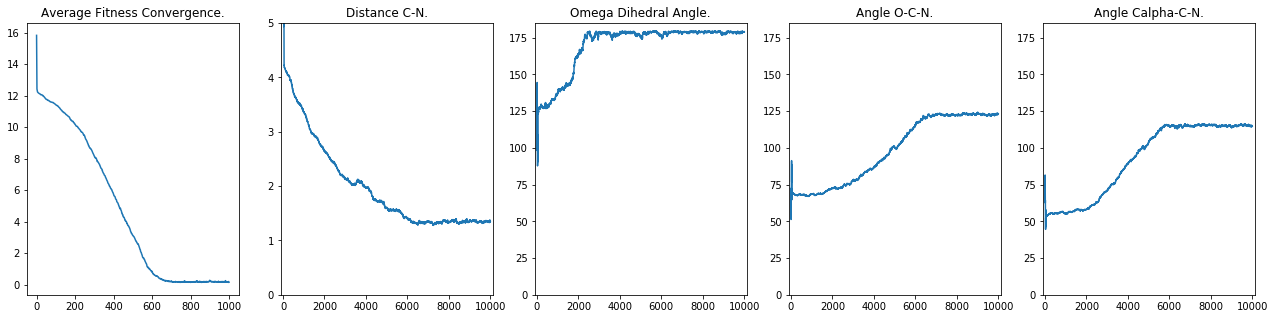

Amino acid CYS added.



In [18]:
protein = _infer_tertiary_structure(primary_structure, aminoacids)

In [19]:
protein.head(20)

,atom_name,residue_name,residue_seq_number,x,y,z
0,N,THR,0,0.080000,-0.083000,0.000000
1,CA,THR,0,1.539000,-0.033000,0.000000
2,C,THR,0,2.032000,1.394000,0.000000
3,O,THR,0,1.268000,2.339000,0.000000
4,CB,THR,0,2.116000,-0.818000,-1.226000
5,OG1,THR,0,1.743000,-2.188000,-1.162000
6,CG2,THR,0,3.654000,-0.842000,-1.361000
7,1H,THR,0,-0.523000,0.813000,0.000000
8,2H,THR,0,-0.461000,-1.018000,0.000000
9,HA,THR,0,1.904000,-0.508000,0.929000


# Q2) PHI and PSI angles

**Reference Plane:** The reference plane for both phi and psi contains three atoms: the nitrogen in the amino group, the alpha carbon, and the carbon in the carboxyl group.

**PHI:** The plane for phi contains the carboxyl carbon from the previous segment, plus the amino nitrogen and the alpha carbon from the segment in question. Phi is the angle between this plane and the reference plane.

<h5><center>PHI atoms: C(i-1)-N(i)-Calpha(i)-C(i)</center></h5>

**PHI:** The plane for psi contains the amino nitrogen from the next segment, plus carboxyl carbon and the alpha carbon from the segment in question. Psi is the angle between this plane and the reference plane.

<h5><center>PSI atoms: N(i)-Calpha(i)-C(i)-N(i+1)</center></h5>

Source: https://www.open.edu/openlearn/science-maths-technology/science/biology/proteins/content-section-1.2

In [21]:
def _infer_phi(c_previous, n_current, c_alpha_current, c_current):
    return calculate_dihedral_angle(c_previous, n_current, c_alpha_current, c_current)


def _infer_psi(n_current, c_alpha_current, c_current, n_next):
    return calculate_dihedral_angle(n_current, c_alpha_current, c_current, n_next)


def infer_phi_psi(protein):
    phi_psi = pd.DataFrame(data=None, columns=['amino', 'phi', 'psi'])    
    previous_aminoacid = None
    
    for i in protein.residue_seq_number.unique():
        current_aminoacid = protein[protein.residue_seq_number == str(i)].copy()
        next_aminoacid = protein[protein.residue_seq_number == str(int(i)+1)].copy() 
        next_aminoacid = next_aminoacid if not next_aminoacid.empty else None
        
        c_previous = previous_aminoacid[previous_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)\
                     if previous_aminoacid is not None else None
        n_current = current_aminoacid[current_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)
        c_alpha_current = current_aminoacid[current_aminoacid.atom_name == 'CA'][['x', 'y', 'z']].values.reshape(-1)
        c_current = current_aminoacid[current_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)
        n_next = next_aminoacid[next_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)\
                 if next_aminoacid is not None else None

        
        phi = _infer_phi(c_previous, n_current, c_alpha_current, c_current) if previous_aminoacid is not None else None
        psi = _infer_psi(n_current, c_alpha_current, c_current, n_next) if next_aminoacid is not None else None
        
        previous_aminoacid = current_aminoacid
        
        new_phi_psi = pd.DataFrame(data={'amino': [current_aminoacid.residue_name.iloc[0]], 
                                         'phi': [phi], 
                                         'psi':[psi]})  
        phi_psi = phi_psi.append(new_phi_psi, sort=True, ignore_index=True)

    return phi_psi

In [22]:
phi_psi = infer_phi_psi(protein)

In [23]:
phi_psi

,amino,phi,psi
0,THR,NaN,177.588
1,THR,2.526768,177.439
2,CYS,104.546548,179.043
3,CYS,160.216664,None


# Q3) Ramachandran Plot

In [24]:
ramachandran = infer_phi_psi(molecule)

In [25]:
ramachandran.head()

,amino,phi,psi
0,THR,NaN,147.66
1,THR,107.832573,144.346
2,CYS,131.170389,133.291
3,CYS,118.896523,151.203
4,PRO,76.181506,18.9794


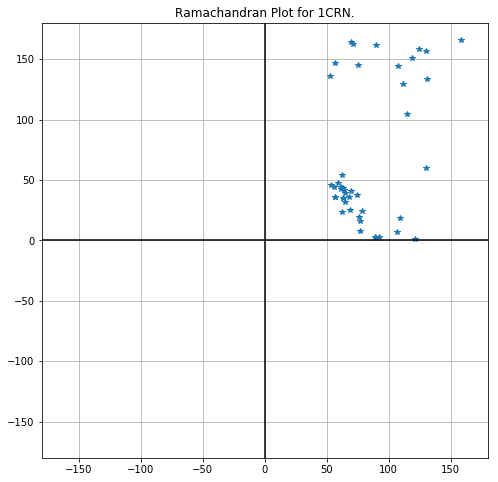

In [26]:
plt.figure(figsize=(8,8))
plt.title('Ramachandran Plot for 1CRN.')
plt.plot(ramachandran.phi, ramachandran.psi, '*')
plt.plot(np.linspace(-180, 180, len(ramachandran.phi)), np.zeros(len(ramachandran.psi)), 'k')
plt.plot(np.zeros(len(ramachandran.phi)), np.linspace(-180, 180, len(ramachandran.psi)), 'k')
plt.grid()
plt.axis([-180, 180, -180, 180])
plt.show()

Done!